In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import lime
import lime.lime_tabular


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, delimiter=";")

# Create binary target
data['quality'] = data['quality'].apply(lambda x: 1 if x >= 7 else 0)  # 1 for high quality, 0 for low quality


# Split the data into features and target
columns_to_drop=['quality','pH','density','free sulfur dioxide','total sulfur dioxide','residual sugar','chlorides']
# 删除多个列
X = data.drop(columns=columns_to_drop)
y = data["quality"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
X_train

,fixed acidity,volatile acidity,citric acid,sulphates,alcohol
493,8.7,0.690,0.31,0.74,11.6
354,6.1,0.210,0.40,0.59,11.9
342,10.9,0.390,0.47,0.75,9.8
834,8.8,0.685,0.26,0.47,9.4
705,8.4,1.035,0.15,0.49,9.9
...,...,...,...,...,...
1130,9.1,0.600,0.00,0.63,10.4
1294,8.2,0.635,0.10,0.75,10.9
860,7.2,0.620,0.06,0.54,9.5
1459,7.9,0.200,0.35,0.80,11.9


In [6]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [7]:
# import joblib
# model = joblib.load('./xgb_model.joblib')
# 预测并评估模型
y_pred = model.predict(X_train)
y_test_pred= model.predict(X_test)
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')

Accuracy: 1.0
Accuracy: 0.88125


In [8]:
import shap
# Compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

In [9]:
test_shap_values = explainer.shap_values(X_test)

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
# Train the regression model
# 创建 SHAP 值的二元标签
shap_values_array = shap_values.values
# Define thresholds

# Initialize the label array
shap_binary_labels = np.zeros(shap_values_array.shape, dtype=int)

# Assign categories
# shap_binary_labels[shap_values_array > positive_threshold] = 3  # Strong positive
# shap_binary_labels[(shap_values_array > 0) & (shap_values_array <= positive_threshold)] = 1  # Positive
# shap_binary_labels[(shap_values_array < 0) & (shap_values_array >= negative_threshold)] = 0  # Negative
# shap_binary_labels[shap_values_array < negative_threshold] = 2  # Strong negative

shap_binary_labels[shap_values_array > 0] = 1  # Strong positive
# shap_binary_labels[(shap_values_array > 0) & (shap_values_array <= positive_threshold)] = 1  # Positive
# shap_binary_labels[(shap_values_array < 0) & (shap_values_array >= negative_threshold)] = 0  # Negative
shap_binary_labels[shap_values_array < 0] = 0  # Strong negative





# shap_binary_labels = (shap_values_array > 0).astype(int)  # 1 为正，0 为负


# Identify categorical features
categorical_features = []
numerical_features = [col for col in X.columns if col not in categorical_features]

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
        # ('cat', OneHotEncoder(), categorical_features)
    ]
)


# Random Forest classifier
# base_clf = RandomForestClassifier(n_estimators=100, random_state=42)

base_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
multi_target_clf = MultiOutputClassifier(base_clf, n_jobs=-1)

# Create the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multi_target_clf)
])


# Train the multi-output classifier
pipeline.fit(X_train.astype(np.float32), shap_binary_labels)

# Evaluate the model on the training set
y_pred_train = pipeline.predict(X_train.astype(np.float32))
# Print classification report for each output
for i in range(shap_binary_labels.shape[1]):
    print(f"Classification Report for Output {i}:")
    print(classification_report(shap_binary_labels[:, i], y_pred_train[:, i]))

# Optionally, you can calculate and print the average accuracy
accuracies = []
for i in range(shap_binary_labels.shape[1]):
    accuracies.append(np.mean(shap_binary_labels[:, i] == y_pred_train[:, i]))

average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")


Classification Report for Output 0:
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       728
           1       0.75      0.41      0.53       551

    accuracy                           0.69      1279
   macro avg       0.71      0.66      0.65      1279
weighted avg       0.71      0.69      0.67      1279

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90       784
           1       0.96      0.66      0.79       495

    accuracy                           0.86      1279
   macro avg       0.89      0.82      0.84      1279
weighted avg       0.88      0.86      0.85      1279

Classification Report for Output 2:
              precision    recall  f1-score   support

           0       0.68      0.98      0.80       580
           1       0.97      0.62      0.76       699

    accuracy                           0.78      1279
   macro avg       0

In [11]:
test_shap_values_array = test_shap_values
# Initialize the label array
test_shap_binary_labels = np.zeros(test_shap_values_array.shape, dtype=int)

# Assign categories
test_shap_binary_labels[test_shap_binary_labels > 0] = 1  # Strong positive
test_shap_binary_labels[test_shap_binary_labels < 0] = 0  # Strong negative


# Evaluate the model on the training set
y_pred_test = pipeline.predict(X_test.astype(np.float32))
# Print classification report for each output
# for i in range(test_shap_binary_labels.shape[1]):
    # print(f"Classification Report for Output {i}:")
    # print(classification_report(test_shap_binary_labels[:, i], y_pred_test[:, i]))

# Optionally, you can calculate and print the average accuracy
accuracies = []
for i in range(test_shap_binary_labels.shape[1]):
    accuracies.append(np.mean(test_shap_binary_labels[:, i] == y_pred_test[:, i]))

average_accuracy = np.mean(accuracies)
print(f"Test Average Accuracy: {average_accuracy}")

Test Average Accuracy: 0.666875


In [12]:
# Select a specific instance (e.g., the first instance in the test set)
instance_index = 27
instance_scaled = pipeline.named_steps['preprocessor'].transform(X_train.iloc[[instance_index]]).astype(np.float32)
instance_original = X_train.iloc[instance_index].values.reshape(1, -1).astype(np.float32)

feature_names = ['fixed acidity',
                 'volatile acidity',	
                 'citric acid',
                #  'residual sugar',
                #  'chlorides',
                #  'free sulfur dioxide',
                #  'total sulfur dioxide',
                #  'density',
                #  'pH',
                 'sulphates',
                 'alcohol'
]    


# Initialize the rules dictionary
rules_dict = {feature_name: [] for feature_name in feature_names}

# Get the decision path for the instance and generate natural language explanations
multi_target_clf = pipeline.named_steps['classifier']

# Ensure the data is in the correct dtype
X = X.astype(np.float32)

# Identify numerical and categorical feature indices
numerical_features_indices = [X.columns.get_loc(feature) for feature in numerical_features]
cat_features_indices = [X.columns.get_loc(feature) for feature in categorical_features]

for i, estimator in enumerate(multi_target_clf.estimators_):
    node_indicator = estimator.decision_path(instance_scaled)
    leaf_id = estimator.apply(instance_scaled)
    
    feature_indices = estimator.tree_.feature
    impurities = estimator.tree_.impurity
    n_node_samples = estimator.tree_.n_node_samples
    node_depth = estimator.tree_.decision_path(instance_scaled).toarray().sum(axis=0)
    
    # Sort nodes by depth (starting from the root)
    sorted_node_index = sorted(node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]], key=lambda x: node_depth[x])
    contribution_value = shap_binary_labels[instance_index, i]
    
    if contribution_value == 3:
            contribution_desc = "strong positive"
    elif contribution_value == 2:
            contribution_desc = "strong negative"
    elif contribution_value == 1:
            contribution_desc = "positive"
    else:
            contribution_desc = "negative"

    
    print(f"{feature_names[i]}: shap value {contribution_desc}")
    for node_id in sorted_node_index:
        if leaf_id == node_id:
            continue

        # Get the relevant information for the decision node
        feature_index = feature_indices[node_id]
        if feature_index == -2:
            continue

        node_importance = impurities[node_id]
        sample_count = n_node_samples[node_id]

        if feature_index in numerical_features_indices:  # Numerical feature
            feature_name = X.columns[feature_index]
            feature_value_scaled = instance_scaled[0, feature_index]
            feature_value_original = instance_original[0, feature_index]
            
            # Inverse transform to get the original threshold value
            threshold_value_scaled = estimator.tree_.threshold[node_id]
            threshold_value_array = np.zeros((1, len(numerical_features)))
            threshold_value_array[0, numerical_features_indices.index(feature_index)] = threshold_value_scaled
            threshold_value_original = preprocessor.named_transformers_['num'].inverse_transform(threshold_value_array)[0, numerical_features_indices.index(feature_index)]

            if feature_value_original <= threshold_value_original:
                threshold_sign = "<="
            else:
                threshold_sign = ">"  
        elif feature_index in cat_features_indices:  # One-hot encoded categorical feature
            category_index = np.where(cat_features_indices == feature_index)[0]
            if len(category_index) > 0:
                category_index = category_index[0]
                one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
                one_hot_feature_name = one_hot_feature_names[category_index]
                feature_name, category_name = one_hot_feature_name.split('_', 1)
                feature_value_original = instance_original[0, list(X.columns).index(feature_name)]
                threshold_sign = "="
                threshold_value_original = category_name
            else:
                continue  # If there's no match, skip this node
        if node_importance > 0.1:
            # Add the rule to the dictionary
            rules_dict[feature_names[i]].append((feature_name, feature_value_original, threshold_sign, threshold_value_original, node_importance, sample_count))

            # Generate the natural language explanation
            explanation = (
            # f"importance: {node_importance:.2f}"
            f" feature '{feature_name}': {feature_value_original:.2f} {threshold_sign} {threshold_value_original:.2f}. "
            f" Contributes the prediction: {feature_names[i]}={contribution_desc}. "
            )
            print(explanation)
    
    print("\n")


fixed acidity: shap value negative
 feature 'fixed acidity': 7.00 <= 7.15.  Contributes the prediction: fixed acidity=negative. 
 feature 'sulphates': 0.60 > 0.42.  Contributes the prediction: fixed acidity=negative. 


volatile acidity: shap value negative
 feature 'volatile acidity': 0.69 > 0.41.  Contributes the prediction: volatile acidity=negative. 
 feature 'volatile acidity': 0.69 > 0.66.  Contributes the prediction: volatile acidity=negative. 


citric acid: shap value positive
 feature 'citric acid': 0.00 <= 0.18.  Contributes the prediction: citric acid=positive. 


sulphates: shap value negative
 feature 'sulphates': 0.60 <= 0.62.  Contributes the prediction: sulphates=negative. 
 feature 'citric acid': 0.00 <= 0.03.  Contributes the prediction: sulphates=negative. 


alcohol: shap value negative
 feature 'alcohol': 9.70 <= 11.08.  Contributes the prediction: alcohol=negative. 
 feature 'alcohol': 9.70 <= 9.95.  Contributes the prediction: alcohol=negative. 




SHAP Values for Target fixed acidity


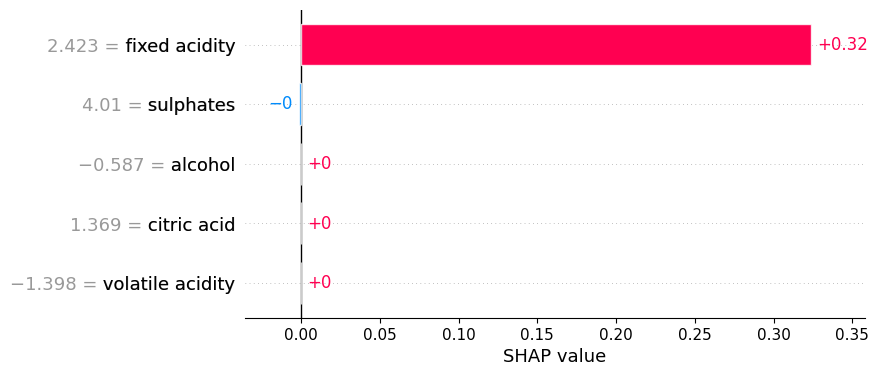

SHAP Values for Target volatile acidity


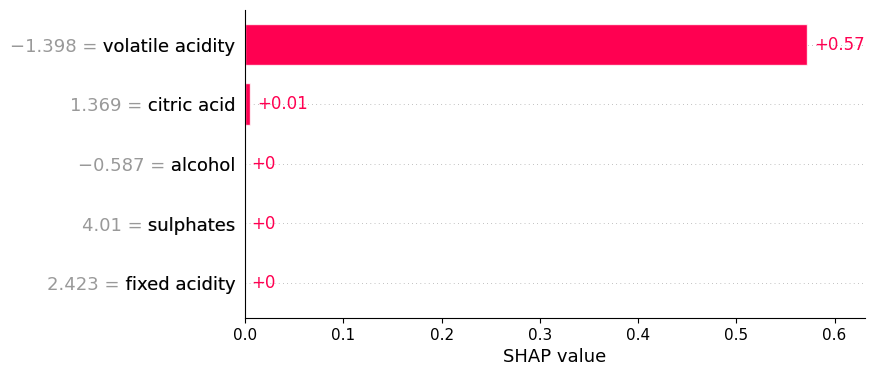

SHAP Values for Target citric acid


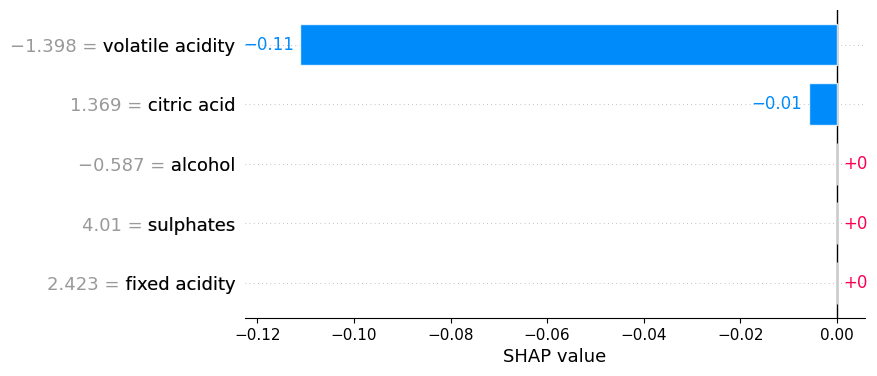

SHAP Values for Target sulphates


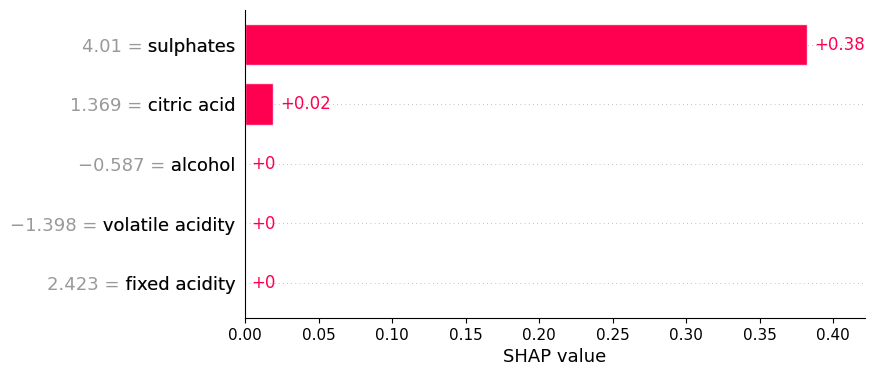

SHAP Values for Target alcohol


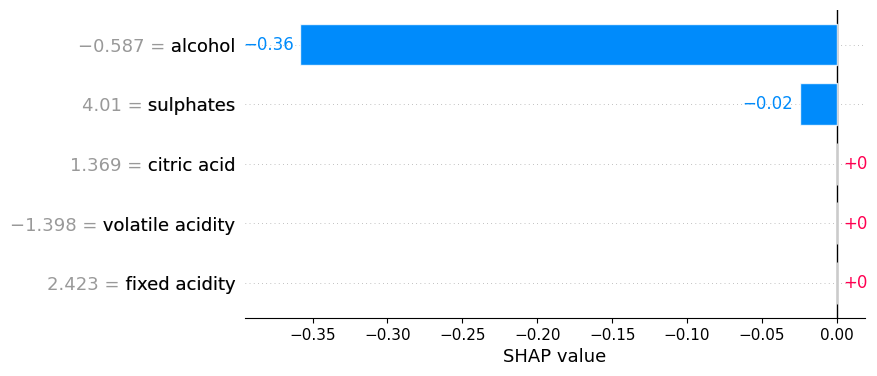

In [14]:
# Calculate SHAP values for the training data using SHAP library
X_train_scaled = preprocessor.transform(X_train.astype(np.float32))
# Generate SHAP values and plots for each output
instance_index = 17
instance_scaled = X_train_scaled[instance_index].reshape(1, -1)

# Define feature names after preprocessing

all_feature_names = numerical_features 


feature_names = ['fixed acidity',
                 'volatile acidity',	
                 'citric acid',
                #  'residual sugar',
                #  'chlorides',
                #  'free sulfur dioxide',
                #  'total sulfur dioxide',
                #  'density',
                #  'pH',
                 'sulphates',
                 'alcohol'
] 
# Generate SHAP values for each estimator (one per target variable)
for output_idx, estimator in enumerate(multi_target_clf.estimators_):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer(instance_scaled)

    # Select the SHAP values for the specific class (e.g., class 1)
    shap_values_class_1 = shap_values[..., 1] if shap_values.shape[-1] > 1 else shap_values

    # Create SHAP Explanation object
    shap_exp = shap.Explanation(values=shap_values_class_1[0], base_values=explainer.expected_value[1] if explainer.expected_value.size > 1 else explainer.expected_value, data=instance_scaled, feature_names=all_feature_names)
    print(f'SHAP Values for Target {feature_names[output_idx]}')
    # Generate bar plot for the current output
    shap.plots.bar(shap_exp, max_display=len(all_feature_names))
    # plt.title(f'SHAP Values for Target {output_idx}')
    plt.show()

In [118]:
rules_dict

{'cap-diameter': [('stem-width', 1023, '>', 468.4999880842097, 'positive'),
  ('stem-width', 1023, '<=', 2570.500015814104, 'positive'),
  ('stem-width', 1023, '<=', 1156.4999999507236, 'positive'),
  ('cap-diameter', 202, '<=', 526.500000167447, 'positive'),
  ('stem-height', 243, '<=', 243.49999989101485, 'positive'),
  ('season', 2, '<=', 2.500000026396498, 'positive'),
  ('does-bruise-or-bleed', 0, '<=', 0.4999999971621193, 'positive'),
  ('cap-diameter', 202, '<=', 268.5000001538539, 'positive'),
  ('stem-height', 243, '>', 111.9999925319708, 'positive'),
  ('stem-height', 243, '>', 240.49999867379643, 'positive'),
  ('cap-diameter', 202, '<=', 203.50000838391702, 'positive')],
 'does-bruise-or-bleed': [('does-bruise-or-bleed',
   0,
   '<=',
   0.4999999971621193,
   'negative'),
  ('stem-height', 243, '<=', 920.4999922582225, 'negative'),
  ('cap-diameter', 202, '>', 42.50000188435399, 'negative'),
  ('cap-diameter', 202, '>', 116.5000084897676, 'negative'),
  ('stem-height', 24

In [124]:
# 合并规则并生成解释
combined_explanations = {}
for feature_name, rules in rules_dict.items():
    positive_conditions = []
    negative_conditions = []

    for feature, value, sign, threshold, contribution in rules:
        condition = f"{feature}={value} is {sign} {threshold}"
        if contribution == "positive":
            positive_conditions.append(condition)
        else:
            negative_conditions.append(condition)

    combined_explanation = ""
    if positive_conditions:
        combined_explanation += f"For feature '{feature_name}', the conditions:\n " + " and\n ".join(positive_conditions) + " lead to a positive SHAP value.\n"
    if negative_conditions:
        combined_explanation += f"For feature '{feature_name}', the conditions:\n " + " and\n ".join(negative_conditions) + " lead to a negative SHAP value.\n"
    # print("\n")

    combined_explanations[feature_name] = combined_explanation

# 打印合并后的规则
print("Combined Explanations:")
for feature_name, explanation in combined_explanations.items():
    print(explanation)

Combined Explanations:
For feature 'cap-diameter', the conditions:
 stem-width=1023 is > 468.4999880842097 and
 stem-width=1023 is <= 2570.500015814104 and
 stem-width=1023 is <= 1156.4999999507236 and
 cap-diameter=202 is <= 526.500000167447 and
 stem-height=243 is <= 243.49999989101485 and
 season=2 is <= 2.500000026396498 and
 does-bruise-or-bleed=0 is <= 0.4999999971621193 and
 cap-diameter=202 is <= 268.5000001538539 and
 stem-height=243 is > 111.9999925319708 and
 stem-height=243 is > 240.49999867379643 and
 cap-diameter=202 is <= 203.50000838391702 lead to a positive SHAP value.

For feature 'does-bruise-or-bleed', the conditions:
 does-bruise-or-bleed=0 is <= 0.4999999971621193 and
 stem-height=243 is <= 920.4999922582225 and
 cap-diameter=202 is > 42.50000188435399 and
 cap-diameter=202 is > 116.5000084897676 and
 stem-height=243 is <= 843.5000054259219 and
 cap-diameter=202 is > 139.49999856416622 and
 stem-height=243 is <= 826.4999953562335 and
 cap-diameter=202 is > 199.499

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
# Train the regression model
# 创建 SHAP 值的二元标签
shap_binary_labels = (shap_values_array > 0).astype(int)  # 1 为正，0 为负

# 缩放原始特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

# 训练多输出分类器
base_clf = DecisionTreeClassifier(random_state=42)
multi_target_clf = MultiOutputClassifier(base_clf, n_jobs=-1)
multi_target_clf.fit(X_train_scaled, shap_binary_labels)

# 在测试集上进行预测并评估模型
# shap_values_test = explainer(X_test_)
# shap_values_test_array = shap_values_test.values[:, :-2]  # Remove the last two SHAP features if needed
# shap_binary_labels_test = (shap_values_test_array > 0).astype(int)  # Binary labels for the test set

y_pred_train = multi_target_clf.predict(X_train_scaled)

# 计算每个目标的准确率
accuracy = accuracy_score(shap_binary_labels, y_pred_train)
print(f"Overall Accuracy: {accuracy}")



Overall Accuracy: 1.0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
# Train the regression model
# 创建 SHAP 值的二元标签
shap_binary_labels = (shap_values_array > 0).astype(int)  # 1 为正，0 为负

# 缩放原始特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

# 训练多输出分类器
base_clf = DecisionTreeClassifier(random_state=42)
multi_target_clf = MultiOutputClassifier(base_clf, n_jobs=-1)
multi_target_clf.fit(X_train_scaled, shap_binary_labels)

# 在测试集上进行预测并评估模型
# shap_values_test = explainer(X_test_)
# shap_values_test_array = shap_values_test.values[:, :-2]  # Remove the last two SHAP features if needed
# shap_binary_labels_test = (shap_values_test_array > 0).astype(int)  # Binary labels for the test set

y_pred_train = multi_target_clf.predict(X_train_scaled)

# 计算每个目标的准确率
accuracy = accuracy_score(shap_binary_labels, y_pred_train)
print(f"Overall Accuracy: {accuracy}")



Overall Accuracy: 1.0


In [77]:
y_pred_test = multi_target_clf.predict(X_train_scaled)

In [79]:
# Print shapes for debugging
print(f"Shape of shap_binary_labels_test: {shap_binary_labels.shape}")
print(f"Shape of y_pred_test: {y_pred_test.shape}")

Shape of shap_binary_labels_test: (48855, 6)
Shape of y_pred_test: (48855, 6)


array([[1, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0],
       ...,
       [0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1]])

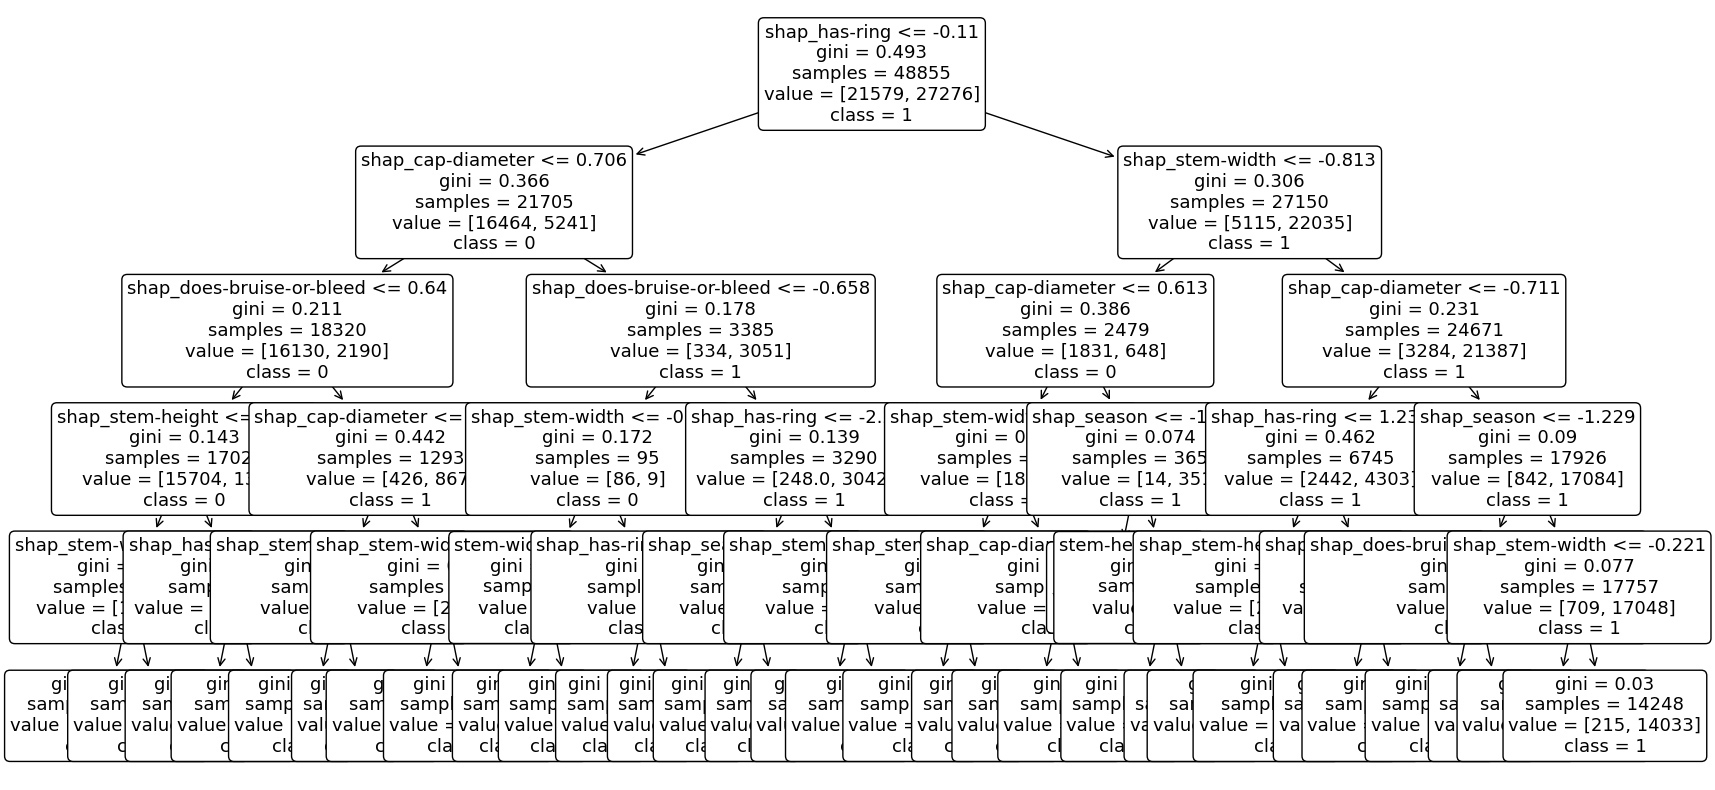

In [63]:
feature_names = [  'stem-width',
                   'stem-height',
                   'cap-diameter',
                   'has-ring',
                   'does-bruise-or-bleed',
                   'season']
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Visualize the decision tree
plt.figure(figsize=(20, 10))
# Combine original feature names and SHAP feature names
feature_names = list(X.columns) + [f'shap_{feature_names[i]}' for i in range(shap_values_array.shape[1])]

plot_tree(shallow_model,max_depth=5, fontsize=13, filled=False, rounded=True, feature_names=feature_names, class_names=np.unique(y).astype(str))
plt.show()

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plot_tree(shallow_model, max_depth=3,filled=False, feature_names=['stem-height','stem-width'], class_names=['e','p'], rounded=True,fontsize=12)
plt.show()

In [11]:
augmented_X_train

array([[ 2.02000000e+02,  0.00000000e+00,  2.43000000e+02, ...,
        -2.60952703e+00,  1.30117383e+00,  1.91749033e-01],
       [ 4.19000000e+02,  0.00000000e+00,  5.33000000e+02, ...,
         2.22672166e+00, -4.42770076e-01,  3.73001607e-01],
       [ 7.24000000e+02,  0.00000000e+00,  5.00000000e+02, ...,
         2.95720759e+00, -1.26331169e-01, -4.51889004e-01],
       ...,
       [ 1.18300000e+03,  0.00000000e+00,  9.69000000e+02, ...,
        -8.07555978e-01,  2.30523783e-01,  2.07026566e-01],
       [ 6.33000000e+02,  1.00000000e+00,  5.33000000e+02, ...,
        -5.03125903e-01, -4.25449977e-02, -8.07934185e-02],
       [ 6.67000000e+02,  0.00000000e+00,  5.20000000e+01, ...,
         1.42218525e-01,  1.25129930e-01,  5.43521643e-01]])

In [ ]:
shap_values_test = explainer.shap_values(X_test)

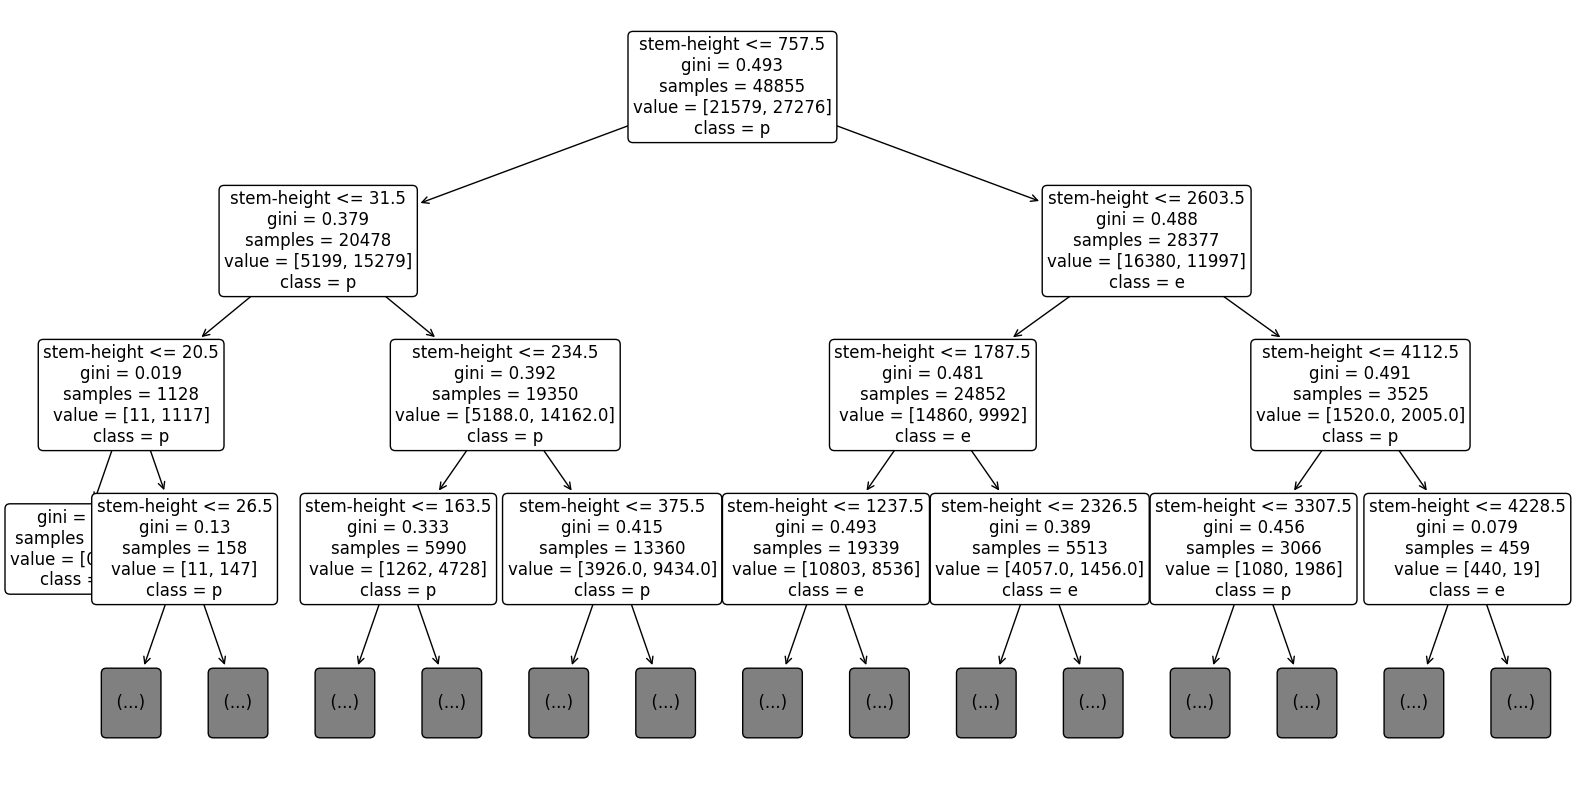

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plot_tree(shallow_model, max_depth=3,filled=False, feature_names=['stem-height','stem-width'], class_names=['e','p'], rounded=True,fontsize=12)
plt.show()

In [25]:
feature_names = X.columns.tolist()

# 打印特征名称列表
print("Feature Names List:")
print(feature_names)

Feature Names List:
['cap-diameter', 'does-bruise-or-bleed', 'stem-height', 'stem-width', 'has-ring', 'season']


In [30]:
import joblib
# 保存模型到本地文件
joblib.dump(model, 'xgb_model.joblib')

['xgb_model.joblib']

In [65]:
import shap
explainer = shap.Explainer(model, X_train)
instance = X_train.iloc[0]
shap_values = explainer(X_train)

100%|===================| 48844/48855 [01:24<00:00]        

In [64]:
shap_values

NameError: name 'shap_values' is not defined

[0]
[1]


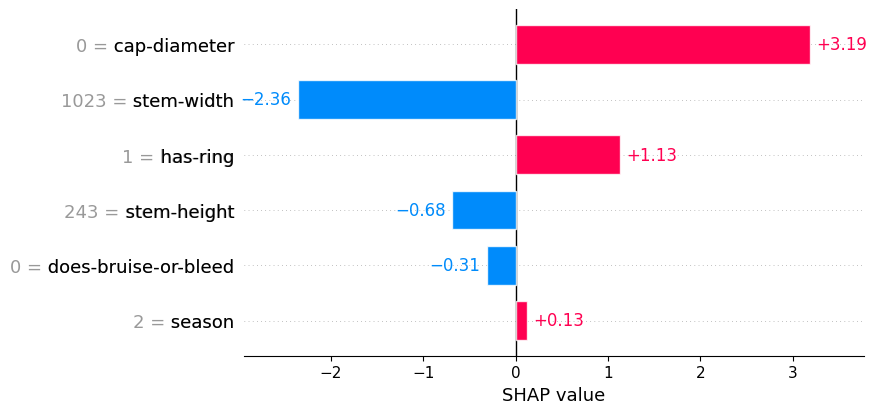

In [58]:
instance = X_train.iloc[0].copy()
print(model.predict([instance]))
instance['cap-diameter'] = 0
shap_value = explainer(instance)
print(model.predict([instance]))
shap.plots.bar(shap_value)

In [65]:
from sklearn.tree import DecisionTreeRegressor, export_text
# 计算 SHAP 值
shap_values = explainer.shap_values(X_train)

# 确保 SHAP 值的形状与 X_train 的样本数一致
if len(shap_values) != len(X_train):
    raise ValueError("The shape of SHAP values does not match the number of samples in X_train")

# 使用 SHAP 值计算每个样本的 SHAP 值之和
X_train_with_shap = X_train.copy()
X_train_with_shap['shap_value'] = np.abs(shap_values).sum(axis=1)

# 训练决策树回归模型
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_train, X_train_with_shap['shap_value'])

# 提取并打印规则
rules = export_text(tree_model, feature_names=list(X_train.columns))
print("Extracted Rules from Decision Tree:")
print(rules)

# 基于规则生成注释
def generate_rule_based_annotations(instance, tree_model, feature_names):
    # 获取特征的值
    instance_values = instance.values.reshape(1, -1)
    decision_path = tree_model.decision_path(instance_values)
    
    rules_applied = []
    feature_index = tree_model.tree_.feature
    threshold = tree_model.tree_.threshold
    node_indicator = decision_path.indices
    
    for node_id in node_indicator:
        if feature_index[node_id] != -2:
            feature = feature_names[feature_index[node_id]]
            rule_value = instance[feature]
            rule_threshold = threshold[node_id]
            if rule_value <= rule_threshold:
                rules_applied.append(f"{feature} <= {rule_threshold:.2f}")
            else:
                rules_applied.append(f"{feature} > {rule_threshold:.2f}")

    return rules_applied

# 获取某个实例
instance_index = 0
instance = X_train.iloc[instance_index]

# 生成基于规则的注释
annotations = generate_rule_based_annotations(instance, tree_model, list(X_train.columns))
print("\nGenerated Annotations for the Instance:")
for annotation in annotations:
    print(annotation)

100%|===================| 48785/48855 [01:23<00:00]        

Extracted Rules from Decision Tree:
|--- stem-height <= 81.50
|   |--- stem-height <= 4.50
|   |   |--- season <= 2.50
|   |   |   |--- value: [10.91]
|   |   |--- season >  2.50
|   |   |   |--- value: [12.32]
|   |--- stem-height >  4.50
|   |   |--- season <= 2.50
|   |   |   |--- value: [9.25]
|   |   |--- season >  2.50
|   |   |   |--- value: [10.42]
|--- stem-height >  81.50
|   |--- cap-diameter <= 1120.50
|   |   |--- has-ring <= 0.50
|   |   |   |--- value: [4.03]
|   |   |--- has-ring >  0.50
|   |   |   |--- value: [5.40]
|   |--- cap-diameter >  1120.50
|   |   |--- stem-width <= 2923.50
|   |   |   |--- value: [5.89]
|   |   |--- stem-width >  2923.50
|   |   |   |--- value: [7.70]


Generated Annotations for the Instance:
stem-height > 81.50
cap-diameter <= 1120.50
has-ring > 0.50


/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


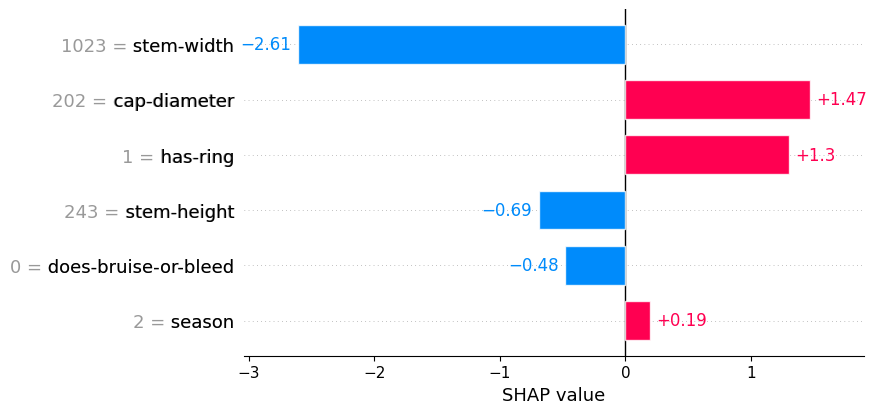

In [40]:
shap.plots.bar(shap_values[0])

In [7]:
max_abs_shap_value = np.max(np.abs([value.values for value in shap_values]))
print("max_abs_shap_value",max_abs_shap_value)

max_abs_shap_value 8.049500501404982


In [59]:
index = 0  # 选择第一个实例，你可以根据需要选择其他实例
instance = X_train.iloc[index]
instance_shap_values = shap_values[index]

In [61]:
instance_shap_values

0.84357819

In [60]:
# 计算每个特征的 SHAP 值
instance_feature_importance = pd.DataFrame(list(zip(X_train.columns, instance_shap_values.values)), columns=['feature', 'importance'])
instance_feature_importance = instance_feature_importance.sort_values(by='importance', ascending=False, key=abs)
print(instance_feature_importance)


AttributeError: 'numpy.float64' object has no attribute 'values'

In [56]:
# 输入数据
features = ['cap-diameter', 'does-bruise-or-bleed', 'gill-color', 'stem-height', 'stem-width', 'has-ring', 'season']
shap_values = np.array([0.84357819, -0.32757508, -0.48504226, -0.88088634, -1.54990394, 0.98807072, 0.02482514])
data = {
    'cap-diameter': 202,
    'does-bruise-or-bleed': False,
    'gill-color': 7,
    'stem-height': 243,
    'stem-width': 1023,
    'has-ring': True,
    'season': 'summer'
}

# 生成所有可能的关系
def generate_relations(features, shap_values):
    relations = []
    # 单一特征关系
    for i, (feature, shap_value) in enumerate(zip(features, shap_values)):
        relations.append((f"{feature} leads to", shap_value))
    
    # 组合特征关系
    for comb in itertools.combinations(range(len(features)), 2):
        feature_comb = [features[i] for i in comb]
        shap_value_comb = [shap_values[i] for i in comb]
        combined_shap_value = sum(shap_value_comb) / len(shap_value_comb)
        relations.append((f"{' and '.join(feature_comb)} lead to A{comb[0]+1} and A{comb[1]+1}", combined_shap_value))
    
    return relations
relations = generate_relations(features,shap_values)

In [58]:
# 生成文字注释
def generate_annotations(important_relations):
    annotations = []
    for relation in important_relations:
        annotations.append(f"Relation: {relation[0]} influence: {relation[1]:.3f}")
    return annotations

generate_annotations(relations)

['Relation: cap-diameter leads to influence: 0.844',
 'Relation: does-bruise-or-bleed leads to influence: -0.328',
 'Relation: gill-color leads to influence: -0.485',
 'Relation: stem-height leads to influence: -0.881',
 'Relation: stem-width leads to influence: -1.550',
 'Relation: has-ring leads to influence: 0.988',
 'Relation: season leads to influence: 0.025',
 'Relation: cap-diameter and does-bruise-or-bleed lead to A1 and A2 influence: 0.258',
 'Relation: cap-diameter and gill-color lead to A1 and A3 influence: 0.179',
 'Relation: cap-diameter and stem-height lead to A1 and A4 influence: -0.019',
 'Relation: cap-diameter and stem-width lead to A1 and A5 influence: -0.353',
 'Relation: cap-diameter and has-ring lead to A1 and A6 influence: 0.916',
 'Relation: cap-diameter and season lead to A1 and A7 influence: 0.434',
 'Relation: does-bruise-or-bleed and gill-color lead to A2 and A3 influence: -0.406',
 'Relation: does-bruise-or-bleed and stem-height lead to A2 and A4 influence:

In [40]:
y_pred = model.predict([instance])

In [62]:
import shap
import matplotlib.pyplot as plt
# Compute SHAP values
explainer = shap.Explainer(model, X_train)

In [76]:
index = 100
instance = X_train.iloc[index]
instance_shap_values = explainer(instance)
# 计算每个特征的 SHAP 值
instance_feature_importance = pd.DataFrame(list(zip(X_train.columns, instance_shap_values.values)), columns=['feature', 'importance'])
instance_feature_importance = instance_feature_importance.sort_values(by='importance', ascending=False, key=abs)

from copy import deepcopy

# 初始预测
initial_prediction = model.predict([instance])[0]

# 保留特征的重要性阈值（可以调整）
importance_threshold = 1

# 逐步移除不重要的特征
current_instance = deepcopy(instance)
removed_features = []

for feature in instance_feature_importance['feature']:
    if abs(instance_feature_importance[instance_feature_importance['feature'] == feature]['importance'].values[0]) < importance_threshold:
        current_instance = current_instance.drop(labels=[feature])
        removed_features.append(feature)
        current_instance[feature] = 0  # 将移除的特征值设为0或其他合理默认值
        
        current_prediction = model.predict([current_instance])[0]
        print("current_prediction",current_prediction,initial_prediction)
        
        print(f'Removed feature: {feature}, Prediction: {current_prediction}')
        
        if current_prediction != initial_prediction:
            # 如果移除该特征后预测发生变化，则停止移除
            break

print(f'Final retained features: {current_instance.index}')
print(f'Removed features: {removed_features}')


current_prediction 1 1
Removed feature: stem-width, Prediction: 1
current_prediction 1 1
Removed feature: stem-height, Prediction: 1
current_prediction 1 1
Removed feature: does-bruise-or-bleed, Prediction: 1
current_prediction 1 1
Removed feature: cap-diameter, Prediction: 1
current_prediction 1 1
Removed feature: gill-color, Prediction: 1
current_prediction 1 1
Removed feature: has-ring, Prediction: 1
current_prediction 1 1
Removed feature: season, Prediction: 1
Final retained features: Index(['stem-width', 'stem-height', 'does-bruise-or-bleed', 'cap-diameter',
       'gill-color', 'has-ring', 'season'],
      dtype='object')
Removed features: ['stem-width', 'stem-height', 'does-bruise-or-bleed', 'cap-diameter', 'gill-color', 'has-ring', 'season']


In [17]:
# 1. 一致性检查
# 检查 SHAP 值与模型预测的一致性
consistent = True
for i in range(5):  # 检查前 5 个样本
    original_prediction = model.predict([X_train.iloc[i]])
    shap_sum = shap_values[i].values.sum() + shap_values[i].base_values
    print(f"Original prediction: {original_prediction}, SHAP sum: {shap_sum}")
    # if not np.isclose(original_prediction, shap_sum, atol=1e-5):
    #     consistent = False
    #     print(f"Inconsistency found at index {i}: original_prediction={original_prediction}, shap_sum={shap_sum}")


# 2. 特征重要性比较
# 比较 SHAP 值和模型特征重要性
# shap_importance = np.abs(shap_values).mean(axis=0)
# model_importance = model.feature_importances_
# print("SHAP feature importance:", shap_importance)
# print("Model feature importance:", model_importance)

Original prediction: [0], SHAP sum: -0.8933287033969306
Original prediction: [1], SHAP sum: 6.863001901766599
Original prediction: [1], SHAP sum: 4.098916776258463
Original prediction: [1], SHAP sum: 4.1068601173932775
Original prediction: [0], SHAP sum: -5.470343426329585


In [21]:
shap_values.shape

(48855, 11)

In [24]:
import pickle
# 保存 shap_values 到本地文件
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [26]:
# 从本地文件加载 shap_values
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [27]:
y_pred_ = model.predict(X_train)
y_pred_[0]

0

In [29]:
shap_values[0]

.values =
array([ 1.48727603, -0.91146642, -0.89171849, -0.30242687, -0.07896475,
       -0.18821719, -1.45066395, -0.75289296,  1.27687627,  0.05393288,
        0.08899657])

.base_values =
0.7759401783512085

.data =
array([ 202,    6,   10,    0,    7,  243, 1023,   11,    1,    1,    2])

In [41]:
shap_values[1]

.values =
-0.32757507655303925

.base_values =
0.45463654815787025

.data =
0

In [36]:
# 找到全局最大绝对值
max_abs_shap_value = np.max(np.abs([value.values for value in shap_values]))

In [37]:
max_abs_shap_value

6.237330045986455

In [ ]:
max_abs_shap_value

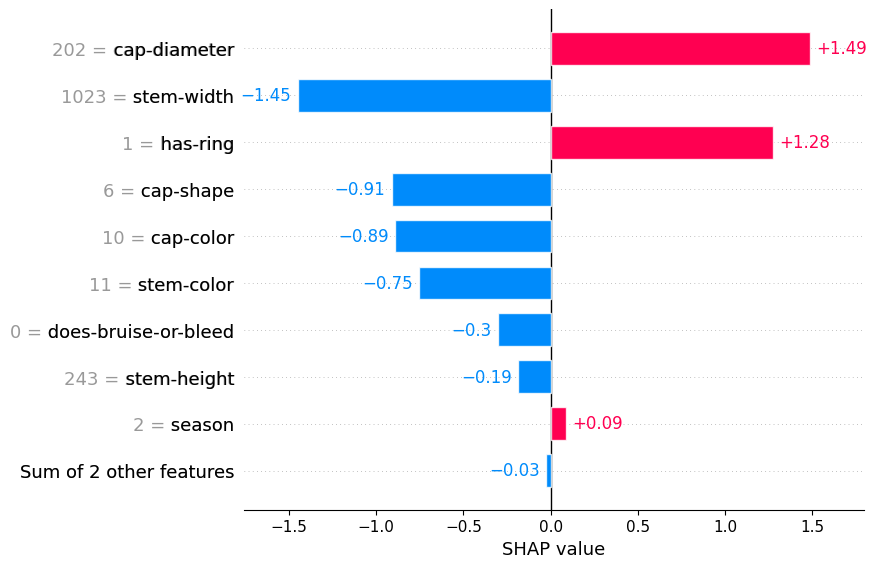

In [28]:
shap.plots.bar(shap_values[0])

In [42]:
# 创建LIME解释器
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['edible', 'poisonous'],
    mode='classification'
)

# 选择一个实例进行解释
i = 17  # 可选择任意测试集中的索引
exp = explainer.explain_instance(X_test.iloc[i], model.predict_proba, num_features=10)

# 显示解释
exp.show_in_notebook(show_table=True)


/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe